# Porcupine Neural Networks

The code here is for testing PNN approximation on MNIST (only 0's and 1's).

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function

import pickle
import numpy as np
import matplotlib.pyplot as plt

import arch
import pnn

np.set_printoptions(precision=2,suppress=True)

%matplotlib inline

maindir = './temp_MNIST_1_2_final'
os.system('mkdir -p %s'%(maindir))

0

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

# subset to just 1's and 0's

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

keep_inds_train = (mnist.train.labels == 1) | (mnist.train.labels == 2)
Xtr = mnist.train.images[keep_inds_train]
Ytr = mnist.train.labels[keep_inds_train].astype(float).reshape(-1, 1)

keep_inds_test = (mnist.test.labels == 1) | (mnist.test.labels == 2)
Xtt = mnist.test.images[keep_inds_test]
Ytt = mnist.test.labels[keep_inds_test].astype(float).reshape(-1, 1)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Network parameters
num_epochs = 1000
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable
d = 784    # number of inputs
k_list = [512, 1024, 2048]

# PNN last layer not trainable

All last layer weights set to 1

In [5]:
# Performance with a dense network
input_dict = dict(p=d, h=512)
save_file = '%s/mlp_noreluout_lastlayernottrainable.pickle'%(maindir)
build_func = arch.mlp_noreluout_lastlayernottrainable

w_init = {'weights1':np.random.normal(0, 1/np.sqrt(d), [d, 512]),
          'weights2':np.ones([512, 1]).astype(np.float32)}

pnn.build_graph_and_train(Xtr, Ytr, Xtt, Ytt, input_dict, build_func, save_file,
                          num_epochs=num_epochs, batch_size=batch_size, w_initial=w_init)

Train acc: 0.99845
Test acc: 0.97600


In [6]:
build_func = arch.mlp_noreluout_lastlayernottrainable
save_pref = '%s/mlp_noreluout_lastlayernottrainable_PNN'%(maindir)
pnn.train_set_of_PNNs(Xtr, Ytr, Xtt, Ytt, k_list, d, build_func, save_pref,
                      num_epochs=num_epochs, batch_size=batch_size, w2_init_mode=1)

Num final lines close to original: 511
Train acc: 0.98592
Test acc: 0.98939
Num final lines close to original: 1024
Train acc: 0.99219
Test acc: 0.99446
Num final lines close to original: 2042
Train acc: 0.99313
Test acc: 0.99262


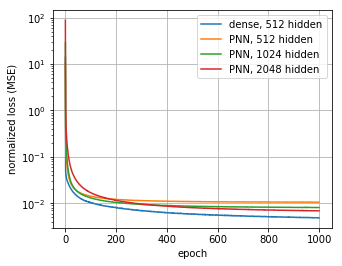

In [7]:
# Plot all losses
plt.figure(figsize=(5, 4))
loss = pickle.load(file('%s/mlp_noreluout_lastlayernottrainable.pickle'%(maindir), 'rb'))[0]
plt.plot(loss, label='dense, 512 hidden')
pnn.plot_losses(k_list, save_pref)
plt.xlabel('epoch')
plt.ylabel('normalized loss (MSE)')
plt.legend()
plt.grid()
plt.yscale('log')
plt.savefig('Figures/fig_pnn_mnist.pdf', format='pdf', dpi=500, bbox_inches='tight')
plt.show()

# PNN last layer trainable

In [8]:
# Performance with a dense network
input_dict = dict(p=d, h=512)
save_file = '%s/mlp_noreluout.pickle'%(maindir)
build_func = arch.mlp_noreluout

w_init = {'weights1':np.random.normal(0, 1/np.sqrt(d), [d, 512]),
          'weights2':np.ones([512, 1]).astype(np.float32)}

pnn.build_graph_and_train(Xtr, Ytr, Xtt, Ytt, input_dict, build_func, save_file,
                          num_epochs=num_epochs, batch_size=batch_size, w_initial=w_init)

Train acc: 0.99391
Test acc: 0.97831


In [9]:
build_func = arch.mlp_noreluout
save_pref = '%s/mlp_noreluout_PNN'%(maindir)
pnn.train_set_of_PNNs(Xtr, Ytr, Xtt, Ytt, k_list, d, build_func, save_pref,
                      num_epochs=num_epochs, batch_size=batch_size, w2_init_mode=2)

Num final lines close to original: 512
Train acc: 0.98918
Test acc: 0.98939
Num final lines close to original: 1024
Train acc: 0.99399
Test acc: 0.99354
Num final lines close to original: 2048
Train acc: 0.99665
Test acc: 0.99492


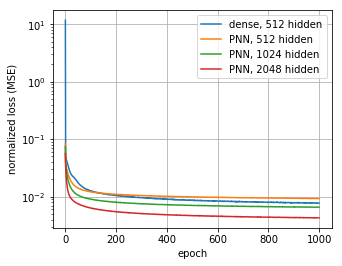

In [11]:
# Plot all losses
plt.figure(figsize=(5, 4))
loss = pickle.load(file('%s/mlp_noreluout.pickle'%(maindir), 'rb'))[0]
plt.plot(loss, label='dense, 512 hidden')
pnn.plot_losses(k_list, save_pref)
plt.xlabel('epoch')
plt.ylabel('normalized loss (MSE)')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()